<div style="text-align: center;"><br>
<img src="https://assets-global.website-files.com/62b9d45fb3f64842a96c9686/62d84db4aeb2f6552f3a2f78_Quantinuum%20Logo__horizontal%20blue.svg" width="200" height="200" /></div>

# Running Circuit Simulations in Nexus

Let's load in a circuit for the quantum phase estimation algorithm.

Quantum phase estimation is of great importance for many quantum algorithms including Quantum chemistry and Shor's factoring algorithm. 

For example code on QPE see the following pytket example notebook -> https://tket.quantinuum.com/examples/phase_estimation.html


For some theory backgound check out the following Quantum Computing Stack exchange post.

https://quantumcomputing.stackexchange.com/questions/32594/how-would-you-draw-the-phase-estimation-circuit-for-the-eigenvalues-of-u-mat/32598#32598



Objective with QPE

Estimate the eigenvalues of a unitary operator $U$ by estimating $\theta$ in the following equation

$$
U |\psi\rangle = e^{2 \pi i \theta} |\psi\rangle
$$

Where $|\psi\rangle$ is an eigenstate of $U$.



Clearly $|11\rangle$ is an eigenstate of $U$ in this case. Which we can prepare with a two $X$ gates.

Our answer will be some binary encoding of the phase $\theta$ in the interval $\theta \in [0, 1)$.

![](images/phase_est.png)


For demo purposes let's choose a trivial example where the matrix is

$$
U = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0  & 1 & 0 & 0 \\ 0 & 0 & e^{i \pi/4} & 0 \\ 0 &  0 & 0 &  e^{i \pi /8} \end{pmatrix}
$$

$$
U |11\rangle = 
\begin{pmatrix}
  0 \\
  0 \\
  0 \\
  e^{i \pi/8} \\
\end{pmatrix}
= e^{i \pi/8} 
\begin{pmatrix}
  0 \\
  0 \\
  0 \\
  1\\
\end{pmatrix}
= e^{i \pi/8}  | 11\rangle
$$

now 
$$
e^{i \pi/8} = e^{2 \pi i \theta} \implies \theta = \frac{1}{16}
$$

Clearly $|11\rangle$ is an eigenstate of $U$ in this case. Which we can prepare with a two $X$ gates.

Building a circuit for $U$ with `DiagonalBox`...

In [1]:
from pytket.circuit import DiagonalBox, CircBox, Circuit, QControlBox
from pytket.circuit.display import render_circuit_jupyter as draw
from pytket.passes import DecomposeBoxes
import numpy as np


u_diagonal = np.array([1, 1, np.e**(1j * np.pi/4), np.e**(1j * np.pi/8)])


d_box = DiagonalBox(u_diagonal)

u_circ = d_box.get_circuit()

DecomposeBoxes().apply(u_circ)

u_circ.name = "U"

draw(u_circ)

In [2]:
u_box = CircBox(u_circ)

In [3]:
unitary_circ = Circuit(2).add_gate(u_box, [0, 1])

In [4]:
unitary_circ.get_unitary()

array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 1.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.70710678+0.70710678j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.92387953+0.38268343j]])

In [5]:
prep_box = CircBox(Circuit(2, name="P").X(0).X(1))

state_circ = Circuit(2).add_gate(prep_box, [0, 1])
draw(state_circ)

In [6]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

In [7]:
draw(build_qft_circuit(n_qubits=3))

In [8]:
def build_phase_estimation_circuit(
    n_measurement_qubits: int, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    # Define a Circuit with a measurement and prep register
    qpe_circ: Circuit = Circuit()
    n_state_prep_qubits = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", n_measurement_qubits)
    state_prep_register = qpe_circ.add_q_register("p", n_state_prep_qubits)
    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    # Create a controlled unitary with a single control qubit
    unitary_circuit.name = "U"
    controlled_u_gate = QControlBox(CircBox(unitary_circuit), 1)

    # Add Hadamard gates to every qubit in the measurement register
    for m_qubit in measurement_register:
        qpe_circ.H(m_qubit)

    # Add all (2**n_measurement_qubits - 1) of the controlled unitaries sequentially
    for m_qubit in range(n_measurement_qubits):
        control_index = n_measurement_qubits - m_qubit - 1
        control_qubit = [measurement_register[control_index]]
        for _ in range(2**m_qubit):
            qpe_circ.add_gate(
                controlled_u_gate, control_qubit + list(state_prep_register)
            )

    # Finally, append the inverse qft and measure the qubits
    qft_box = CircBox(build_qft_circuit(n_measurement_qubits))
    inverse_qft_box = qft_box.dagger
    inverse_qft_box.circuit_name = "QFT†"
    qpe_circ.add_gate(inverse_qft_box, list(measurement_register))
    qpe_circ.measure_register(measurement_register, "c")
    return qpe_circ

In [9]:
qpe_circ = build_phase_estimation_circuit(4, state_prep_circuit=state_circ, unitary_circuit=unitary_circ)

draw(qpe_circ)

In [10]:
from pytket.extensions.nexus import AerConfig, NexusBackend, Nexus

aer_config = AerConfig()


nexus = Nexus()

riken_project = nexus.new_project("demo_project")


New project created: demo_project


In [11]:
aer_backend = NexusBackend(backend_config=aer_config, project=riken_project)


Started using project with name: demo_project


In [12]:
compiled_qpe = aer_backend.get_compiled_circuit(qpe_circ)

In [13]:
aer_result = aer_backend.run_circuit(compiled_qpe, n_shots=1000)

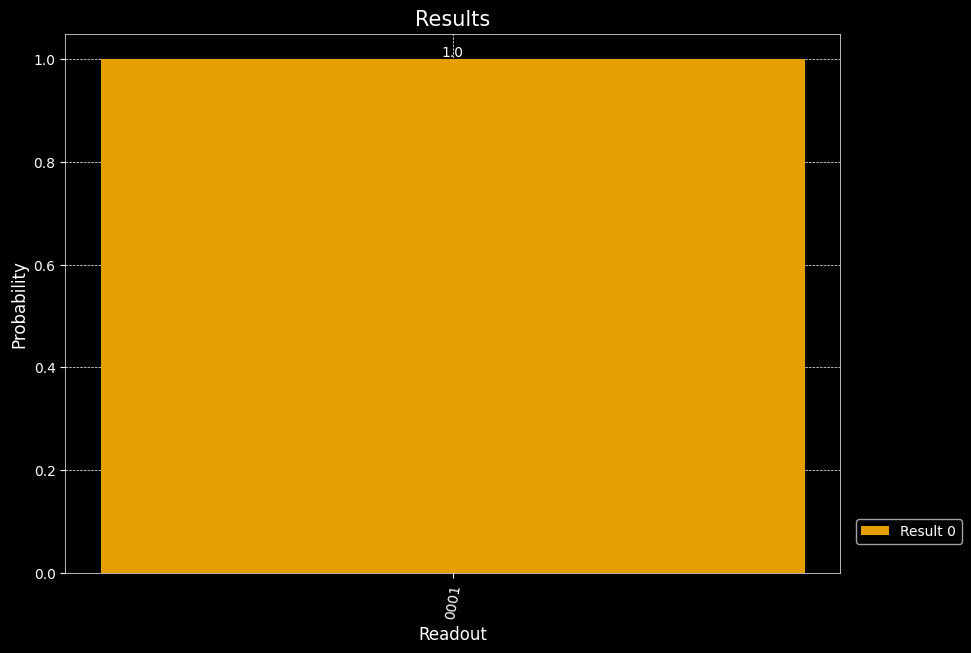

In [14]:
from pytket.extensions.nexus.visualisation import plot_results_histogram

plot_results_histogram([aer_result])

In [15]:
aer_result.get_counts()

Counter({(0, 0, 0, 1): 1000})

Now lets extract the phase from the binary encoding of the basis state...

$$
\begin{equation}
\theta_{estimate} = \frac{j}{N}
\end{equation}
$$

Here $j$ is the binary encoding of the phase `0001 = 1` 

In [16]:
from pytket.backends.backendresult import BackendResult

def single_phase_from_backendresult(result: BackendResult) -> float:
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0]
    bitstring = "".join([str(bit) for bit in basis_state])
    integer_j = int(bitstring, 2)

    # Calculate theta estimate
    return integer_j / (2 ** len(bitstring))

In [17]:
theta = single_phase_from_backendresult(aer_result)

In [18]:
print(theta)

0.0625


In [19]:
1/16

0.0625

In [20]:
from pytket.extensions.nexus import QuantinuumConfig

h_series_config = QuantinuumConfig(device_name="H1-Emulator")

h_series_backend = NexusBackend(backend_config=h_series_config, project=riken_project)


Started using project with name: demo_project


In [21]:
compiled_circ = h_series_backend.get_compiled_circuit(qpe_circ, optimisation_level=0)

In [22]:
draw(compiled_circ)

Expressive parameterised two qubit ZZPhase gate


$$
\text{ZZPhase}(\theta) = e^{-i \frac{\theta \pi}{2} Z \otimes Z}
$$

The number of two qubit entangling gates is a dominant source of error in NISQ circuits and therefore having a small number of two qubit gates is desirable.


Two qubit gate Fidelity on H1-1 is up to
$$
\mathcal{F}= 0.99914(3)
$$

Data sheet for H1-1 

https://www.quantinuum.com/hardware/h1

In [23]:
h_series_result = h_series_backend.run_circuit(compiled_circ, n_shots=1000)

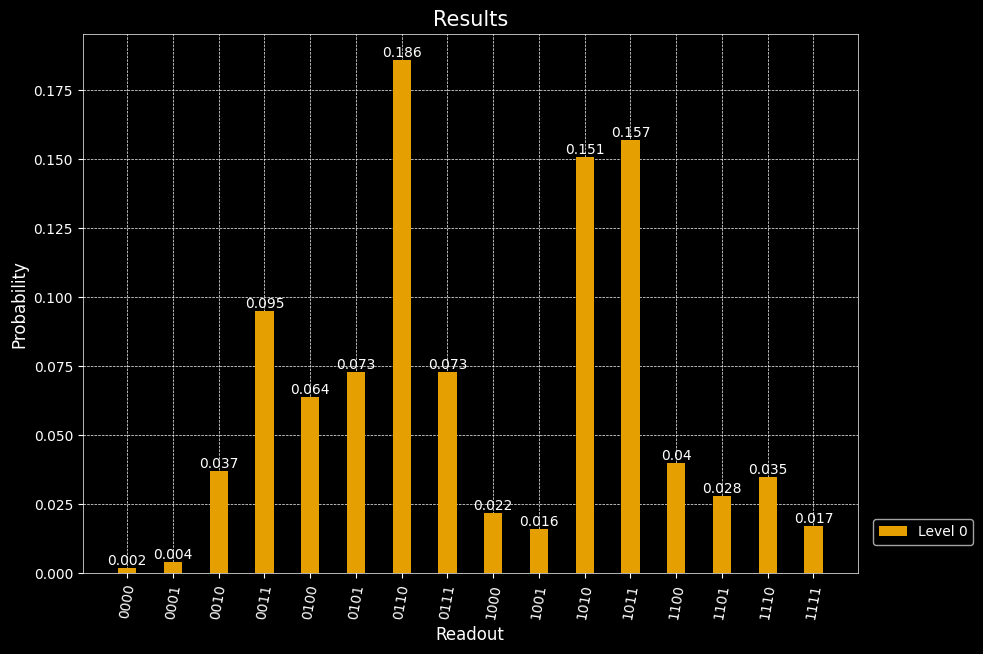

In [24]:
from pytket.extensions.nexus.visualisation import plot_results_histogram

plot_results_histogram(results=[h_series_result], legend=["Level 0"])

In [25]:
compiled_circ2 = h_series_backend.get_compiled_circuit(qpe_circ, optimisation_level=2)

In [26]:
h_series_result2 = h_series_backend.run_circuit(compiled_circ2, n_shots=1000)

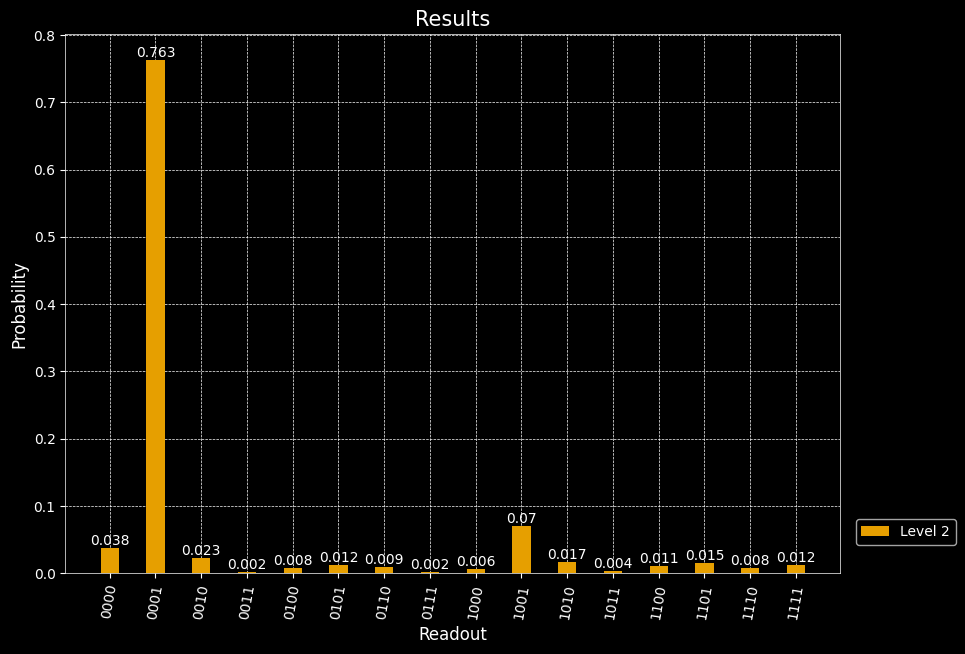

In [27]:
plot_results_histogram(
    results=[h_series_result2],
    legend=["Level 2"],
)